# Testes sobre o algoritmo Multilayer Perceptron
<p>O objetivo é desenvolver uma rede neural MLP que seja capaz de prever um carater. Nesse estudo, será verificado a influência do uso das funções de custo MSE e CrossEntropy, além de analisar o efeito do uso de cross validation e early stopping. Além disso, para busca de hiperparamêtros, será feito uma grid search.</p>
<p>Serão analisadas as seguintes funções de ativação:</p>
- Softmax
- Sigmoid
- ReLU
- Tanh

### Dataset CARACTERES_COMPLETO
<p>X.txt -> Contém os valores dos 120pixels de cada imagem de Letra</p>
<p>Y_letra -> Contém a target do dado</p>
<p>Há 1326 exemplares</p>

In [1]:
import os
import numpy as np

In [2]:
def load_data(path):
    data = []
    with open(path, "r") as file:
        for line in file:
            values = [val.strip() for val in line.strip().split(",") if val.strip() != ""]
            if values:
                data.append([float(v) for v in values])
    return np.array(data, dtype=float)

In [3]:
#path do conjunto de dados
base_dir = os.getcwd()
X_txt_path = os.path.join(base_dir, "..", "CARACTERES_COMPLETO", "X.txt")
Y_txt_path = os.path.join(base_dir, "..", "CARACTERES_COMPLETO", "Y_letra.txt")

In [4]:
X = load_data(X_txt_path)

In [5]:
# Verifica a existência de dados faltantes
comprimentos = [len(linha) for linha in X]
if len(set(comprimentos)) > 1:
    raise ValueError(f"Linhas com tamanhos diferentes detectadas: {set(comprimentos)}")

In [6]:
X

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1., -1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ...,
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]])

<p>Analisando os valores, não é necessário a normalização, pois todas as features estão na mesma escala aproximadamente.</p>

In [7]:
with open(Y_txt_path, "r") as file:
    letters = [line.strip() for line in file]
letter_to_index = {chr(i + 65): i for i in range(26)}
Y = np.array([letter_to_index[l] for l in letters])
n_classes = 26

In [8]:
unique, counts = np.unique(Y, return_counts=True)
index_to_letter = {i: chr(i+65) for i in range(26)}
labels = [index_to_letter[i] for i in unique]

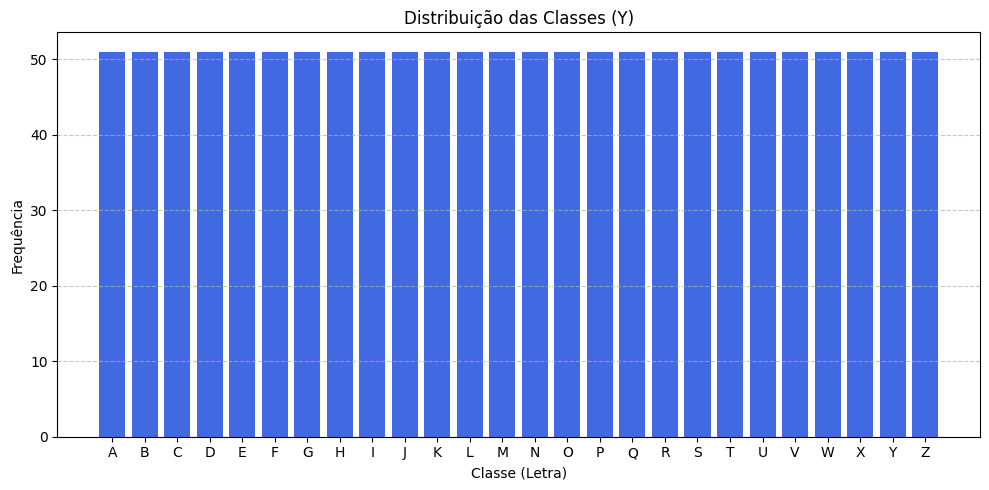

In [9]:
import matplotlib.pyplot as plt

#Gráfico de barras
plt.figure(figsize=(10, 5))
plt.bar(labels, counts, color='royalblue')
plt.xlabel("Classe (Letra)")
plt.ylabel("Frequência")
plt.title("Distribuição das Classes (Y)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<p>Conforme o gráfico de barras, o dataset é balanceado em termos da quantidade de classes. Portanto, a acurácia é uma métrica confiável</p>

In [10]:
# One-hot encoding
y = np.zeros((len(Y), n_classes))
y[np.arange(len(Y)), Y] = 1

### Random Search
<p>Primeiramente, será feito um estudo dos hiperparamêtros para encontrar a melhor configuração. Após encontrar tal configuração, será estudado os quatro cenários propostos pela Professora. Será feito com Validation Cruzada, para evitar o overfitting.</p>

In [11]:
def accurancy(predictions, targets):
    predicted_classes = np.argmax(predictions, axis=1)
    real_classes = np.argmax(targets, axis=1)
    return np.mean(predicted_classes == real_classes)

In [12]:
import sys
sys.path.append("../../WORKIA")

In [13]:
from MLP.mlp import MLP
from MLP.trainer import *
from MLP.losses.loss_crossentropy import LossCrossEntropy 
from MLP.losses.loss_mse import LossMSE
from MLP.activation_functions.ReLU import ReLU
from MLP.activation_functions.sigmoid import Sigmoid
from MLP.activation_functions.softmax import Softmax
from MLP.activation_functions.tanh import Tanh
import itertools
import random

def random_searchMLP(grid, X, y, n_samples=20):
    all_combinations = list(itertools.product(
        grid['n_neurons'],
        grid['activation_hidden'],
        grid['activation_output'],
        grid['learning_rate'],
        grid['epochs']
    ))
    samples = random.sample(all_combinations, 20)
    metrics = []
    for combination in samples:
        n_neurons, act_hidden, act_output, lr, epochs = combination
        trainer = BackPropagationCV(LossCrossEntropy(), lr, epochs)
        configs = [
            (n_neurons, X.shape[1], act_hidden),
            (y.shape[1], n_neurons, act_output)
        ]
        model = MLP(configs, trainer)
        results = model.train(X, y, k=5)
        rs = []
        for result in results:
            rs.append(accurancy(result['predictions'], result['targets']))
        acc = np.mean(rs) #Acurácia média
        std = np.std(rs) #Desvio padrão
        metrics.append({
            'n_neurons': n_neurons,
            'activation_hidden': act_hidden.getName(),
            'activation_output': act_output.getName(),
            'learning_rate': lr,
            'epochs': epochs,
            'accurancy': acc,
            'std': std
        })
    return metrics

In [14]:
grid = {
    'n_neurons': [16, 32, 64, 128],
    'activation_hidden': [ReLU(), Tanh()],
    'activation_output': [Sigmoid(), Softmax()],
    'learning_rate': [0.0001, 0.01, 0.05],
    'epochs': [250, 500, 1000]
}

In [15]:
X_train = X[:-130]
y_train = y[:-130]
X_test = X[-130:]
y_test = y[-130:]

In [16]:
metrics = random_searchMLP(grid, X_train, y_train, 40)

      🧠  Multi-Layer Perceptron Created! 🧠
Multi-Layer Perceptron Configuration
Epochs: 250
Learning rate: 0.05
Number of layers: 2
Architecture:
  Layer 1: 16 neurons - Activation: ReLU
  Layer 2: 26 neurons - Activation: Sigmoid

Epoch 1/250 - Loss: 0.693198
Epoch 100/250 - Loss: 0.561239
Epoch 200/250 - Loss: 0.073345
Epoch 1/250 - Loss: 0.626505
Epoch 100/250 - Loss: 0.397282
Epoch 200/250 - Loss: 0.055045
Epoch 1/250 - Loss: 0.575658
Epoch 100/250 - Loss: 0.375194
Epoch 200/250 - Loss: 0.056408
Epoch 1/250 - Loss: 0.528769
Epoch 100/250 - Loss: 0.289406
Epoch 200/250 - Loss: 0.048293
Epoch 1/250 - Loss: 0.489566
Epoch 100/250 - Loss: 0.229921
Epoch 200/250 - Loss: 0.044748
      🧠  Multi-Layer Perceptron Created! 🧠
Multi-Layer Perceptron Configuration
Epochs: 1000
Learning rate: 0.0001
Number of layers: 2
Architecture:
  Layer 1: 32 neurons - Activation: Tanh
  Layer 2: 26 neurons - Activation: Sigmoid

Epoch 1/1000 - Loss: 0.693623
Epoch 100/1000 - Loss: 0.693487
Epoch 200/1000 -

In [40]:
import pandas as pd
import seaborn as sns

def plot_accuracy_heatmap(metrics, x_label, y_label):
    # Crie um DataFrame com as métricas para fácil manipulação
    accuracy_data = []
    
    for metric in metrics:
        row = [
            metric['n_neurons'],
            metric['activation_hidden'],
            metric['activation_output'],
            metric['learning_rate'],
            metric['epochs'],
            metric['accurancy'],
            metric['std']
        ]
        accuracy_data.append(row)

    accuracy_df = pd.DataFrame(accuracy_data, columns=['n_neurons', 'activation_hidden', 'activation_output', 'learning_rate', 'epochs', 'accurancy', 'std'])

    
    accuracy_df['annot'] = accuracy_df['accurancy'].round(2).astype(str) + '±' + accuracy_df['std'].round(2).astype(str)

    # Pivot com agregação (caso hajam duplicatas)
    heatmap_data = accuracy_df.pivot_table(
        index=y_label,
        columns=x_label,
        values='accurancy',
        aggfunc='mean'  # ou np.mean
    )

    # Nova forma: calcule a média e o desvio padrão diretamente
    mean_df = accuracy_df.pivot_table(index=y_label, columns=x_label, values='accurancy', aggfunc='mean')
    std_df = accuracy_df.pivot_table(index=y_label, columns=x_label, values='std', aggfunc='mean')

    # Formata a anotação com base nas médias reais
    annot_data = mean_df.round(2).astype(str) + '±' + std_df.round(2).astype(str)

    # Plote a matriz de acurácia com um heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data, annot=annot_data, cmap='viridis', fmt='', cbar_kws={'label': 'Acurácia Média'})
    plt.title('Média ± Desvio Padrão da Acurácia')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

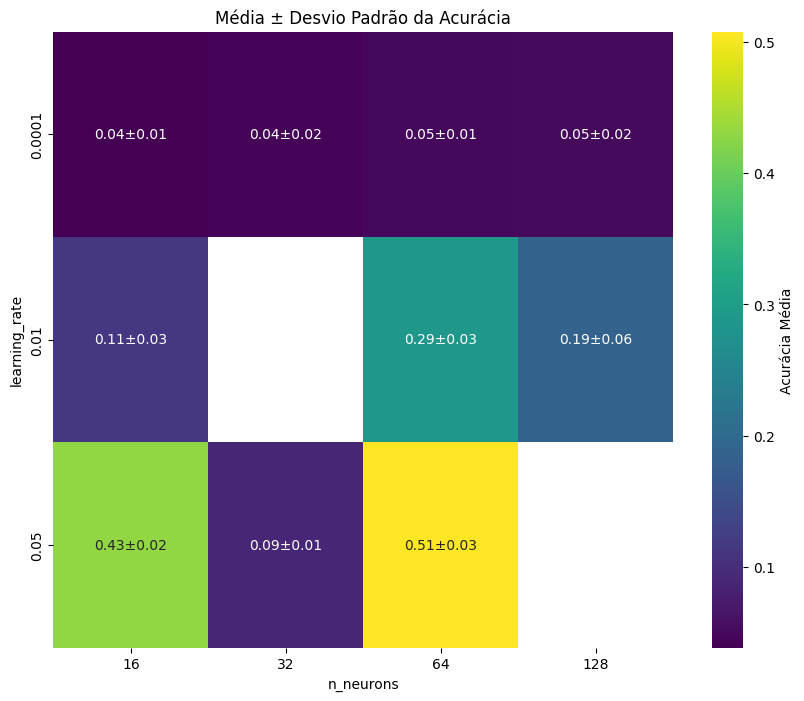

In [41]:
plot_accuracy_heatmap(metrics,'n_neurons', 'learning_rate')

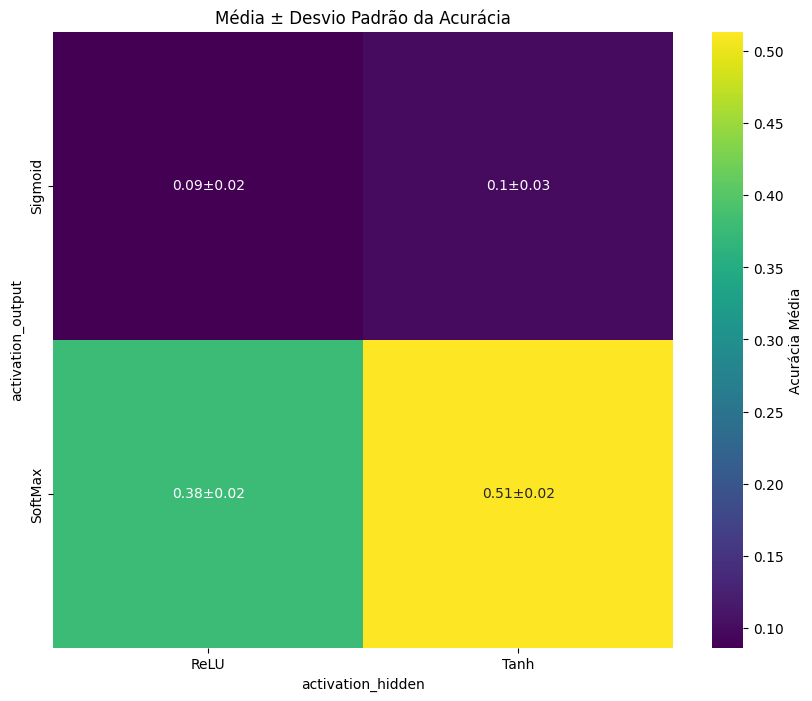

In [42]:
plot_accuracy_heatmap(metrics,'activation_hidden', 'activation_output')

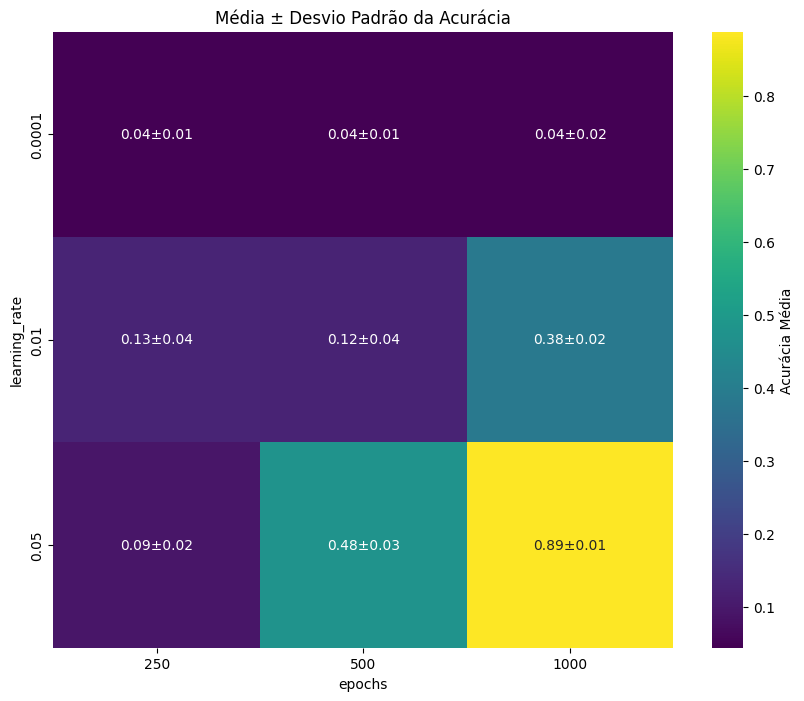

In [43]:
plot_accuracy_heatmap(metrics,'epochs', 'learning_rate')

In [21]:
df = pd.DataFrame(metrics)
id = df['accurancy'].idxmax()
print(df.loc[id])

n_neurons                  64
activation_hidden        Tanh
activation_output     SoftMax
learning_rate            0.05
epochs                   1000
accurancy            0.888632
std                  0.014911
Name: 17, dtype: object


<p>De acordo com os resultados, percebe-se que a melhor configuração de hiperparamêtros é: </p>


### Análise do uso de Cross Validation e Early Stopping

#### Sem Validação Cruzada e Early Stopping

In [23]:
better_params = df.loc[id]
better_params['n_neurons']

64

In [25]:
configs = [
    (better_params['n_neurons'], X_train.shape[1], Tanh()),
    (y_train.shape[1], better_params['n_neurons'], Softmax())
]
model = MLP(
    configs,
    BackPropagation(LossCrossEntropy(), better_params['learning_rate'], better_params['epochs'])
)

      🧠  Multi-Layer Perceptron Created! 🧠
Multi-Layer Perceptron Configuration
Epochs: 1000
Learning rate: 0.05
Number of layers: 2
Architecture:
  Layer 1: 64 neurons - Activation: Tanh
  Layer 2: 26 neurons - Activation: SoftMax



In [26]:
model.train(X_train, y_train)

Epoch 1/1000 - Loss: 3.257889
Epoch 100/1000 - Loss: 3.017351
Epoch 200/1000 - Loss: 2.124776
Epoch 300/1000 - Loss: 1.453922
Epoch 400/1000 - Loss: 1.055273
Epoch 500/1000 - Loss: 0.801891
Epoch 600/1000 - Loss: 0.635627
Epoch 700/1000 - Loss: 0.520619
Epoch 800/1000 - Loss: 0.437290
Epoch 900/1000 - Loss: 0.374644
Epoch 1000/1000 - Loss: 0.326082


In [27]:
y_pred = model.predict(X_test)

In [29]:
print(f"Accurancy: {accurancy(y_pred, y_test)}")

Accurancy: 0.7846153846153846


### Com Validação cruzada

In [31]:
model = MLP(
    configs,
    BackPropagationCV(LossCrossEntropy(), better_params['learning_rate'], better_params['epochs'])
)

results = model.train(X_train, y_train, k=5)

      🧠  Multi-Layer Perceptron Created! 🧠
Multi-Layer Perceptron Configuration
Epochs: 1000
Learning rate: 0.05
Number of layers: 2
Architecture:
  Layer 1: 64 neurons - Activation: Tanh
  Layer 2: 26 neurons - Activation: SoftMax

Epoch 1/1000 - Loss: 3.257449
Epoch 100/1000 - Loss: 3.001478
Epoch 200/1000 - Loss: 2.127667
Epoch 300/1000 - Loss: 1.437409
Epoch 400/1000 - Loss: 1.027707
Epoch 500/1000 - Loss: 0.772132
Epoch 600/1000 - Loss: 0.605481
Epoch 700/1000 - Loss: 0.491757
Epoch 800/1000 - Loss: 0.410556
Epoch 900/1000 - Loss: 0.350124
Epoch 1000/1000 - Loss: 0.303551
Epoch 1/1000 - Loss: 3.259258
Epoch 100/1000 - Loss: 3.014670
Epoch 200/1000 - Loss: 2.144397
Epoch 300/1000 - Loss: 1.452284
Epoch 400/1000 - Loss: 1.042410
Epoch 500/1000 - Loss: 0.782782
Epoch 600/1000 - Loss: 0.612554
Epoch 700/1000 - Loss: 0.495283
Epoch 800/1000 - Loss: 0.410943
Epoch 900/1000 - Loss: 0.347975
Epoch 1000/1000 - Loss: 0.299399
Epoch 1/1000 - Loss: 3.261404
Epoch 100/1000 - Loss: 3.034972
Epo

In [34]:
acc_avg = np.mean([accurancy(rs['predictions'], rs['targets']) for rs in results])
acc_avg

0.8887179487179487

In [35]:
y_pred = model.predict(X_test)

In [36]:
print(f"Accurancy: {accurancy(y_pred, y_test)}")

Accurancy: 0.8076923076923077


### Com Early Stopping

In [37]:
model = MLP(
    configs,
    BackPropagationES(LossCrossEntropy(), better_params['learning_rate'], better_params['epochs'])
)

model.train(X_train, y_train)

      🧠  Multi-Layer Perceptron Created! 🧠
Multi-Layer Perceptron Configuration
Epochs: 1000
Learning rate: 0.05
Number of layers: 2
Architecture:
  Layer 1: 64 neurons - Activation: Tanh
  Layer 2: 26 neurons - Activation: SoftMax

Epoch 1/1000 - Loss: 3.258132
Epoch 100/1000 - Loss: 3.018230
Epoch 200/1000 - Loss: 2.131716
Epoch 300/1000 - Loss: 1.453264
Epoch 400/1000 - Loss: 1.058774
Epoch 500/1000 - Loss: 0.812555
Epoch 600/1000 - Loss: 0.648188
Epoch 700/1000 - Loss: 0.532130
Epoch 800/1000 - Loss: 0.446790
Epoch 900/1000 - Loss: 0.381994
Epoch 1000/1000 - Loss: 0.331488
Epoch 1/1000 - Loss: 0.331040
Epoch 100/1000 - Loss: 0.291213
Epoch 200/1000 - Loss: 0.258449
Epoch 300/1000 - Loss: 0.231330
Epoch 400/1000 - Loss: 0.208551
Epoch 500/1000 - Loss: 0.189181
Epoch 600/1000 - Loss: 0.172540
Epoch 700/1000 - Loss: 0.158114
Epoch 800/1000 - Loss: 0.145513
Epoch 900/1000 - Loss: 0.134429
Epoch 1000/1000 - Loss: 0.124621
Epoch 1/1000 - Loss: 0.124528
Epoch 100/1000 - Loss: 0.115894
Epo

KeyboardInterrupt: 